c:\python27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


part 2
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
score is: 0.941558441558
[[17  0  0  0  0]
 [ 1 20  0  1  0]
 [ 2  1 47  0  0]
 [ 0  1  3 31  0]
 [ 0  0  0  0 30]]
LR: 0.951322 (0.016240)


c:\python27\lib\site-packages\sklearn\discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
c:\python27\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.790349 (0.040044)
KNN: 0.780830 (0.042625)
CART: 0.899180 (0.032030)
NB: 0.891248 (0.042831)
SVM: 0.547012 (0.061638)


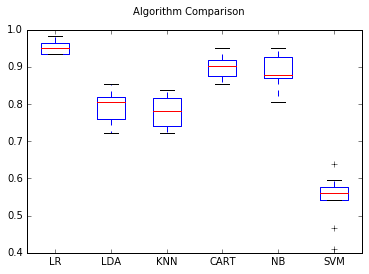

done


In [2]:
import sys
import csv
import gensim
import re
from gensim import corpora, models
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import random
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

def buildAndCleanCSV(fileName,sendersArray):
    dictionariesOfSenders={}
    allWordsOfSenders={}
    row_count=0
    for sender in sendersArray:
        dictionariesOfSenders[sender]=[]

    with open(fileName+'.csv', 'rb') as csv_file:
        csv.field_size_limit(sys.maxint)
        reader = csv.reader(csv_file)
        row_count = sum(1 for row in reader)
    with open(fileName+'.csv', 'rb') as csv_file:
        csv.field_size_limit(sys.maxint)
        reader = csv.reader(csv_file)
        current_row=1
        line = next(reader, None)
        while (line):
            if current_row % 1000==0:
                print('row is: '+str(current_row)+'/'+str(row_count))
            # Remove HTML
            text = BeautifulSoup(line[1], "html.parser").get_text()
            #  Remove non-letters and words longer than 3 letters
            letters_only = re.sub("[^a-zA-Z]", " ", text)
            letters_only = ' '.join(word for word in letters_only.split() if len(word) > 2)
            #lower letters
            letters_only = letters_only.lower()
            # Convert to lower case, split into individual words
            words = letters_only.split()
            # a list, so convert the stop words to a set (faster)
            stops = set(stopwords.words("english"))
            emailStopWords = {'Additional', 'option' ,'for', 'viewing',' and', 'saving', 'the', 'attached', 'documents','http','mass','bgu','ac' ,'il', 'nm', 'php' ,'mm' ,'b' ,'cfe' ,'a','Website', 'www', 'bgu','attachments', 'view', 'npdf', 'pdf', 'alternative', 'view','save', 'additional'}
            # Remove stop words
            meaningful_words = [w for w in words if not w in stops]
            meaningful_words = [w for w in meaningful_words if not w in emailStopWords]
            # 6. Join the words back into one string separated by space and return the result.
            words_combined=" ".join(meaningful_words)
            #stemming
            #porter = nltk.PorterStemmer()
            #[porter.stem(w) for w in words_combined]
            #taking only emails with more than 50 characters to avoid non-informative emails
            if(len(words_combined)>30):
                dictionariesOfSenders[line[0]].append(words_combined.split())
            line = next(reader, None)
            current_row+=1
    sendersBOWlength=[]
    for sender in sendersArray:
        combined=[]
        for tmp in dictionariesOfSenders[sender]:
            combined=combined+tmp
        allWordsOfSenders[sender]=set(combined)
        #BOW size will be the number of different words and if its above 5000, max size will be set to 5000
        sendersBOWlength.append(len(allWordsOfSenders[sender]) if len(allWordsOfSenders[sender])<=5000 else 5000)
    #creating the bag of words
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.
    sendersVectorizers_featureNames={}
    sendersVectorizers_arrays={}
    sendersVectorizers_models={}
    #combine all clean emails from all
    combined_y_label=[]
    text_representation = []
    for sender in sendersArray:
        for emailWordsList in dictionariesOfSenders[sender]:
            combined_y_label.append(sender)
            text_representation.append(" ".join(emailWordsList))
    #vectorizing, we chose max_features to be the max size of the BOW texts length or if higher than 5000 the size will be set to 5000
    sendersVectorizers= CountVectorizer(analyzer="word", \
                             tokenizer=None, \
                             preprocessor=None, \
                             stop_words=None, \
                             max_features=max(sendersBOWlength))
    sendersVectorizers_model = sendersVectorizers.fit_transform(text_representation)
    sendersVectorizers_featureNames=sendersVectorizers.get_feature_names()
    sendersVectorizers_arrays=sendersVectorizers_model.toarray()
    #creating the random forest classifier
    train_data_for_all_x=sendersVectorizers_arrays
    train_data_for_all_y=combined_y_label
    #shuffle the arrays
    c = list(zip(train_data_for_all_x, train_data_for_all_y))
    random.shuffle(c)
    train_data_for_all_x, train_data_for_all_y = zip(*c)
    # split to train & test
    x_train, x_test, y_train, y_test = train_test_split(train_data_for_all_x, train_data_for_all_y, test_size=0.2)

    # Initialize a Random Forest classifier with 100 trees
    forest = RandomForestClassifier(n_estimators = 100)

    # Fit the forest to the training set, using the bag of words as
    # features and the sentiment labels as the response variable
    #
    # This may take a few minutes to run
    forest = forest.fit( x_train, y_train )
    y_test_pred=forest.predict(x_test)
    # Evaluate accuracy best on the test set
    print('score is: ' +str(forest.score(x_test,y_test)))
    #the confusion matrix of the senders of the test data (for random forest):
    print(str(confusion_matrix(y_test, y_test_pred)))
    #comparing more models:
    
    # prepare configuration for cross validation test harness
    seed = 7
    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    models.append(('SVM', SVC()))
    # evaluate each model in turn
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

    print('done')

#main
print('part 2')

nltk.download()
senderlist = ['dean@bgu.ac.il', 'peler@exchange.bgu.ac.il', 'bitahon@bgu.ac.il', 'career@bgu.ac.il',
              'shanigu@bgu.ac.il']
buildAndCleanCSV('filteredBySendersTranslated',senderlist)